## Домашние задания

### Задача 1. В коде из методички реализуйте один или несколько критериев останова (количество листьев, глубина дерева и т.д.)

В этом блокноте реализованы следующие критерии останова: 

* минимальное количество объектов в листе - `min_samples_leaf`, 
* максимальная глубина дерева - `max_depth`,
* максимальное число листьев - `max_leaves`.

In [37]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [38]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000, 
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=5
                                                                         )

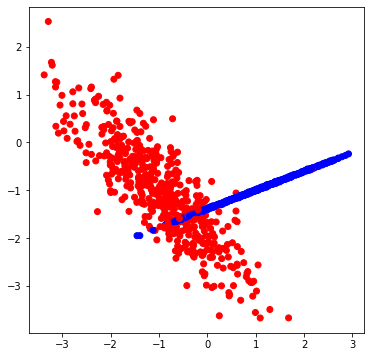

In [39]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [40]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)
train_data.shape

(700, 2)

In [41]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [42]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        # prediction = max(classes, key=classes.get)
        # найдем вероятность встретить класс 1 в листе
        try:
            prediction = classes[1] / (sum(classes.values()))
        except:
            prediction = 0
        return prediction 

In [43]:
# Расчет энтропии Шеннона
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy_ = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p != 0:
            entropy_ -= p * np.log2(p)
    
    return entropy_

In [44]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [45]:
# Расчет качества
def quality(left_labels, right_labels, current_criterion, criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    if criterion == 'entropy':
        return current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

    return current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [46]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [47]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels, min_samples_leaf, criterion):
    # min_samples_leaf - минимальное количество объектов в листе
    
    current_gini = gini(labels)
    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_samples_leaf объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue

            if criterion == 'entropy':
                current_quality = quality(true_labels, false_labels, current_entropy, criterion)
            else:
                current_quality = quality(true_labels, false_labels, current_gini, criterion)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [48]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, min_samples_leaf=1, 
               max_depth=None, depth=0, 
               max_leaves=None, criterion='gini'):
    
    quality, t, index = find_best_split(data, labels, min_samples_leaf, criterion)
    
    global counter_leaf # счетчик листьев
    global counter_node # счетчик узлов
     
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        counter_leaf += 1
        print('== stop: quality' + '\t- ' + str(counter_leaf) + ' leaf')
        return Leaf(data, labels)
    #  Прекращаем рекурсию, когда достигли заданной глубины дерева
    if (max_depth) and (depth >= max_depth):
        counter_leaf += 1
        print('== stop: max_depth' + '\t- ' + str(counter_leaf) + ' leaf')
        return Leaf(data, labels)
    #  Прекращаем рекурсию, когда достигли заданного количества узлов
    if (max_leaves) and (counter_node >= max_leaves - 1):
        counter_leaf += 1
        print('== stop: max_leaves' + '\t- ' + str(counter_leaf) + ' leaf')
        return Leaf(data, labels)
            
     # Вывод для проверки
    if depth == 0: print('level', depth, ': ', len(data))
    print('-------split-------')
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
       
    depth += 1 # текущий уровень дерева
    print('level', depth, ': ', len(true_data), ' + ', len(false_data))
    counter_node += 1
        
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, 
                             min_samples_leaf, max_depth, depth, max_leaves, criterion)
    false_branch = build_tree(false_data, false_labels, 
                             min_samples_leaf, max_depth, depth, max_leaves, criterion)
            
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [50]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [51]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [52]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted, threshold=0.5):
    # для вероятностей
    predicted = np.array(predicted)
    predicted = np.squeeze(np.where([predicted > threshold], 1, 0))
    
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [53]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return
    
    print('========tree========')
    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [54]:
# Построим дерево по обучающей выборке
counter_leaf = 0 # счетчик листьев
counter_node = 0 # счетчик узлов

my_tree = build_tree(train_data, train_labels, min_samples_leaf=10, max_depth=10, max_leaves=5)
print('=' * 27)
print('Количество листьев - ', counter_leaf)
print('Количество узлов - ', counter_node)
print('=' * 27)

#print_tree(my_tree)
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
test_answers = predict(test_data, my_tree)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность на обучающей выборке: {train_accuracy:.2f}')
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность на тестовой выборке: {test_accuracy:.2f}')

level 0 :  700
-------split-------
level 1 :  334  +  366
-------split-------
level 2 :  123  +  211
-------split-------
level 3 :  62  +  61
-------split-------
level 4 :  10  +  52
== stop: quality	- 1 leaf
== stop: quality	- 2 leaf
== stop: max_leaves	- 3 leaf
== stop: quality	- 4 leaf
== stop: max_leaves	- 5 leaf
Количество листьев -  5
Количество узлов -  4
Точность на обучающей выборке: 89.86
Точность на тестовой выборке: 86.00


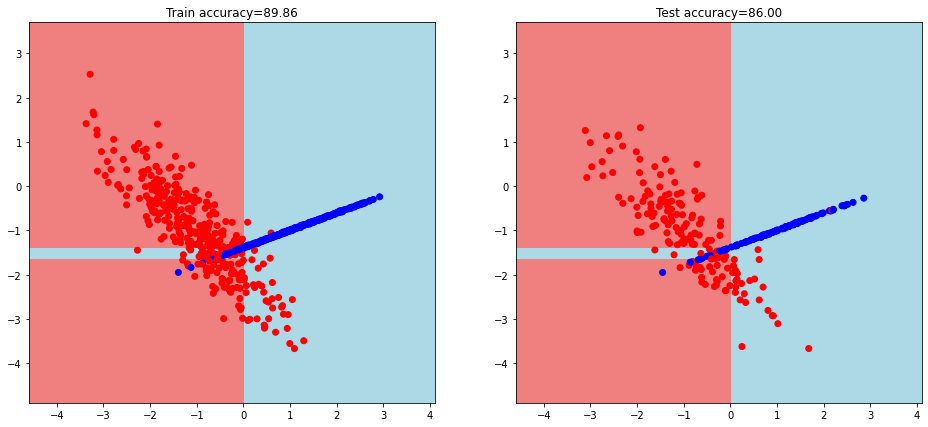

In [55]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}');

### Задача 2. Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

Построим два дерева решений и сравним их точность.

In [19]:
counter_leaf = 0 # счетчик листьев
counter_node = 0 # счетчик узлов
print('TREE with Gini criterion')
my_tree_gini = build_tree(train_data, train_labels, min_samples_leaf=1, max_depth=None, 
                          max_leaves=None)
counter_leaf = 0 # счетчик листьев
counter_node = 0 # счетчик узлов
print(f'\nTREE with Entropy criterion')
my_tree_entropy = build_tree(train_data, train_labels, min_samples_leaf=1, max_depth=None, 
                             max_leaves=None, criterion='entropy')

TREE with Gini criterion
level 0 :  700
-------split-------
level 1 :  334  +  366
-------split-------
level 2 :  123  +  211
-------split-------
level 3 :  62  +  61
-------split-------
level 4 :  1  +  61
== stop: quality	- 1 leaf
-------split-------
level 5 :  8  +  53
-------split-------
level 6 :  7  +  1
-------split-------
level 7 :  2  +  5
-------split-------
level 8 :  1  +  1
== stop: quality	- 2 leaf
== stop: quality	- 3 leaf
== stop: quality	- 4 leaf
== stop: quality	- 5 leaf
== stop: quality	- 6 leaf
-------split-------
level 4 :  13  +  48
== stop: quality	- 7 leaf
-------split-------
level 5 :  21  +  27
-------split-------
level 6 :  13  +  8
-------split-------
level 7 :  8  +  5
-------split-------
level 8 :  4  +  4
== stop: quality	- 8 leaf
-------split-------
level 9 :  2  +  2
-------split-------
level 10 :  1  +  1
== stop: quality	- 9 leaf
== stop: quality	- 10 leaf
== stop: quality	- 11 leaf
== stop: quality	- 12 leaf
== stop: quality	- 13 leaf
-------split---

In [20]:
answers_gini = predict(test_data, my_tree_gini)
print(accuracy_metric(test_labels, answers_gini))

answers_entropy = predict(test_data, my_tree_entropy)
print(accuracy_metric(test_labels, answers_entropy))

95.33333333333334
95.33333333333334


Судя по метрикам, разницы между критериями информативности для этих данных нет.